In [24]:
# Importing Packages
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image, ImageFile
import tensorflow as tf
import json
import glob
import random
import pathlib
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

import gradio as gr
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
# Paths to the dataset
dataset_path = "/kaggle/working/train"
train_data_dir = pathlib.Path(dataset_path + "/images")
test_data_dir = pathlib.Path("/kaggle/working/test/images")

In [14]:
# Prepare training and testing datasets
train_files = glob.glob(r"" + dataset_path + "/images/*.png")
train_files = list(filter(lambda x: "post" in x, train_files))
train_files = random.sample(train_files, 1500)
train_datasize = len(train_files)
print("Training data:", train_datasize)

test_files = glob.glob(r"" + "/kaggle/working/test/images/*.png")
test_files = list(filter(lambda x: "post" in x, test_files))
test_files = random.sample(test_files, 500)
test_datasize = len(test_files)
print("Test data:", test_datasize)

Training data: 1500
Test data: 500


In [15]:
# Image dimensions
img_height = 1024
img_width = 1024
class_names = np.array(['no damage', 'minor damage', 'major damage', 'destroyed'])
print(class_names)

['no damage' 'minor damage' 'major damage' 'destroyed']


In [16]:
# Label extraction function
def get_label(file_path, type):
    parts = file_path.split(os.path.sep)

    # Define path for test labels
    path = dataset_path+'/labels/'
    if type == "test":
        path = '/kaggle/working/test/labels/'
    f = open(path + parts[-1].split('.')[0] +'.json')
    data = json.load(f)

    building_list = data["features"]["xy"]
    total_damage_level = 0
    for i in range(len(building_list)):
        building = building_list[i]
        damage_level = building['properties']['subtype']
        if damage_level == 'no-damage':
            total_damage_level += 0
        elif damage_level == 'minor-damage':
            total_damage_level += 1
        elif damage_level == 'major-damage':
            total_damage_level += 2
        else:
            total_damage_level += 3
    f.close()

    average_damage_level = total_damage_level
    if len(building_list) > 0:
        average_damage_level /= len(building_list)

    label = class_names[round(average_damage_level)] == class_names
    one_hot = np.zeros(len(class_names), dtype=np.uint8)
    one_hot[label] = 1

    return one_hot

# Label decoding function
def get_label_from_one_hot(array):
    return class_names[np.where(array == 1)]

In [17]:
# Preprocessing the training and testing datasets
train_X = np.zeros((train_datasize, img_height, img_width, 3), dtype=np.uint8)
train_Y = np.zeros((train_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(train_files)):
    img = PIL.Image.open(train_files[i])
    train_X[i] = np.array(img)
    train_Y[i] = get_label(train_files[i], "train")
print("Train", train_X.shape, train_Y.shape)

test_X = np.zeros((test_datasize, img_height, img_width, 3), dtype=np.uint8)
test_Y = np.zeros((test_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(test_files)):
    img = PIL.Image.open(test_files[i])
    test_X[i] = np.array(img)
    test_Y[i] = get_label(test_files[i], "test")
print("Test", test_X.shape, test_Y.shape)

Train (1500, 1024, 1024, 3) (1500, 4)
Test (500, 1024, 1024, 3) (500, 4)


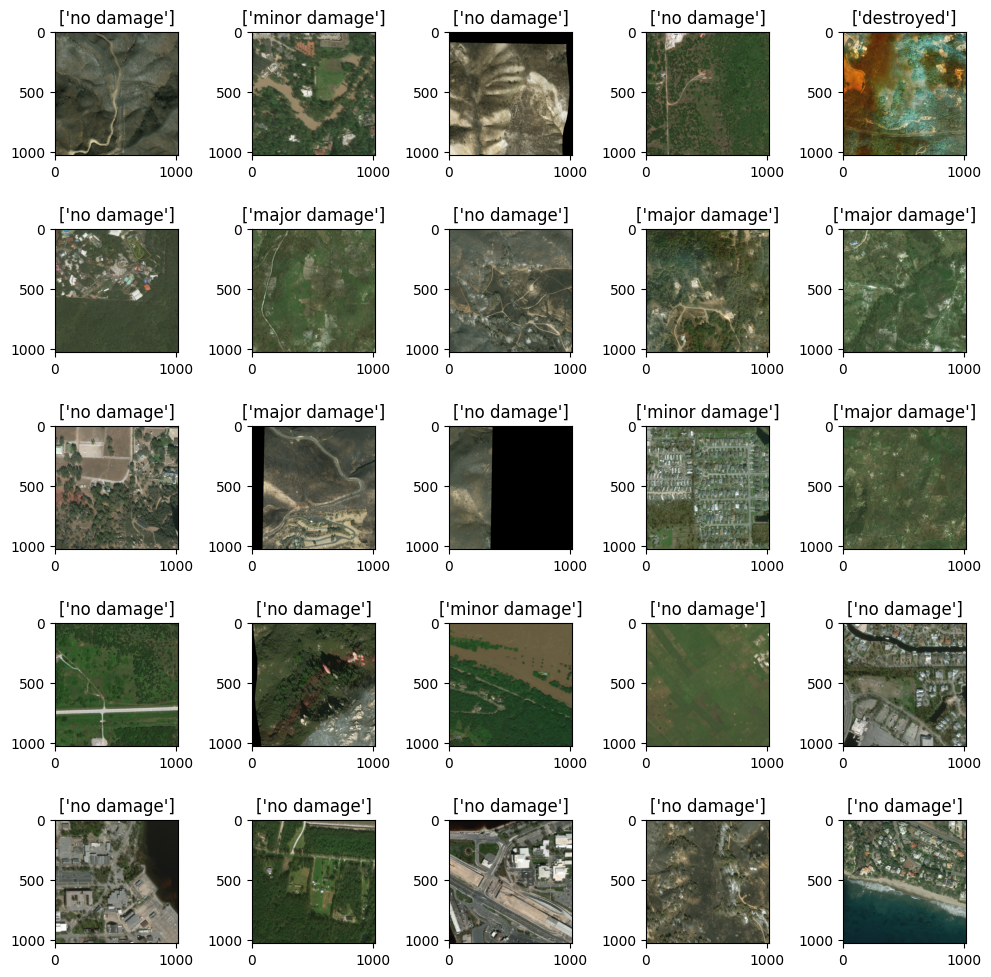

In [18]:
# Plot a few training images with labels
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    choice = random.randint(0, train_datasize-1)
    plt.title(get_label_from_one_hot(train_Y[choice]))
    plt.imshow(train_X[choice])

plt.tight_layout()
plt.show()

In [20]:
# Build the DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the base model

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
model = models.Sequential([
    layers.Input(shape=(1024, 1024, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 32, 32, 1024)        │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,173,828 (27.37 MB)

 Trainable params: 134,020 (523.52 KB)

 Non-trainable params: 7,039,808 (26.85 MB)

In [25]:
# Define the maximum number of epochs
max_epochs = 50
batch_size = 16

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

# Train the model with EarlyStopping
history = model.fit(
    train_X, train_Y,
    validation_data=(test_X, test_Y),
    epochs=max_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]  # Pass the callback
)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.2439 - loss: 4.6071 - val_accuracy: 0.2500 - val_loss: 3.5615
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 85s 907ms/step - accuracy: 0.2821 - loss: 4.1555 - val_accuracy: 0.3780 - val_loss: 3.3398
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 85s 910ms/step - accuracy: 0.3447 - loss: 3.6864 - val_accuracy: 0.4800 - val_loss: 3.0926
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 85s 911ms/step - accuracy: 0.3699 - loss: 3.5481 - val_accuracy: 0.5080 - val_loss: 2.9143
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 86s 911ms/step - accuracy: 0.4251 - loss: 3.2899 - val_accuracy: 0.5620 - val_loss: 2.7593
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 85s 910ms/step - accuracy: 0.4276 - loss: 3.2250 - val_accuracy: 0.6060 - val_loss: 2.6403
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 85s 910ms/step - accuracy: 0.4306 - loss: 3.1133 - val_accuracy: 0.6140 - val_loss: 2.5600
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 85s 910ms/step - accuracy: 0.4579 - loss: 2.9725 - val_accura

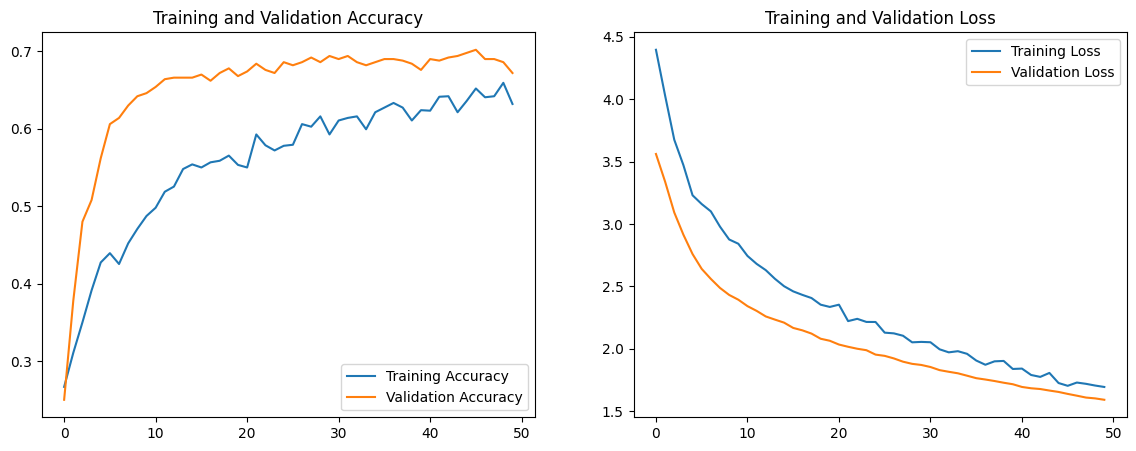

In [27]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(14, 5))

# Training and validation accuracy graph
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Training and validation loss graph
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [31]:
# Evaluate the model on the test dataset
print("\nEvaluating model on test data:\n")
test_loss, test_acc = model.evaluate(test_X, test_Y, verbose=0)

# Print loss and accuracy
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Evaluating model on test data:

Test Accuracy: 0.6720
Test Loss: 1.5912


In [28]:
# Predict on the test dataset
#test_predictions = model.predict(test_X)
#test_pred_labels = np.argmax(test_predictions, axis=1)
#true_test_labels = np.argmax(test_Y, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 188s 6s/step


In [29]:
# Accuracy Score
#accuracy = accuracy_score(true_test_labels, test_pred_labels)
#print(f"\nAccuracy on test data: {accuracy:.4f}")


Accuracy on test data: 0.6720


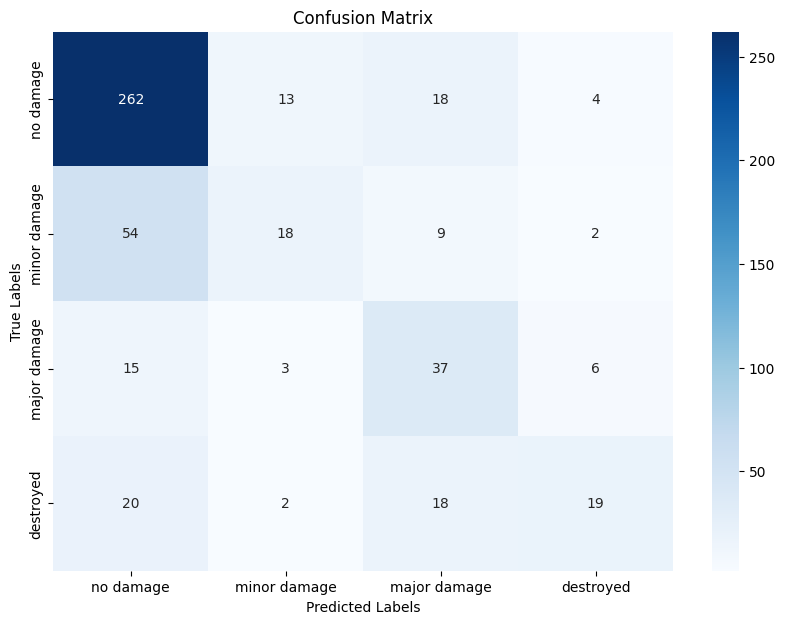

In [32]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_test_labels, test_pred_labels)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [34]:
# Classification Report
report = classification_report(true_test_labels, test_pred_labels, target_names=class_names)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

   no damage       0.75      0.88      0.81       297
minor damage       0.50      0.22      0.30        83
major damage       0.45      0.61      0.52        61
   destroyed       0.61      0.32      0.42        59

    accuracy                           0.67       500
   macro avg       0.58      0.51      0.51       500
weighted avg       0.65      0.67      0.64       500



In [35]:
# Save as a Keras model (Native Keras format)
model.save('Multi_Class_Regional_Damage_Classification_Model.keras')  

# Save as a .h5 file (HDF5 format), explicitly including the optimizer
model.save('Multi_Class_Regional_Damage_Classification_Model.h5', include_optimizer=True)  

# Export as TensorFlow SavedModel format (directory format)
model.export('Multi_Class_Regional_Damage_Classification_Model')

Saved artifact at 'Multi_Class_Regional_Damage_Classification_Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1024, 1024, 3), dtype=tf.float32, name='keras_tensor_427')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138847854338368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138839460930032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138839460932320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138839460922816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138839460928096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138839461757872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138839461764032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138839461761744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138839461762448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138839461767552: TensorSpec(shape=(), dtype=tf

In [39]:
# Gradio Interface for Inference
def disaster_classification(img):
    # Resize the image to the input size expected by the model
    img_resized = np.array(Image.fromarray(img).resize((img_height, img_width)))

    # Normalize the image (1./255 scaling as used in the model's preprocessing layer)
    img_resized = img_resized / 255.0

    # Prepare the image for prediction
    image = np.zeros((1, img_height, img_width, 3), dtype=np.float32)
    image[0] = img_resized

    # Make prediction using the model
    prediction = model.predict(image).tolist()[0]

    # Return a dictionary with class names and their predicted probabilities
    return {class_names[i]: prediction[i] for i in range(len(class_names))}

# Define Gradio interface
iface = gr.Interface(
    fn=disaster_classification,
    inputs=gr.Image(image_mode='RGB', type='numpy'),
    outputs=gr.Label(),
    title="Disaster Regional Damage Classification",
    description="Upload an image to classify the extent of disaster damage."
)

# Launch the interface
iface.launch(share=True, show_error=True, debug=True)


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://b05e1292830daac608.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b05e1292830daac608.gradio.live
